# MouseBrain (MERFISH) Analysis Tutorial

<p style="color:#1E90FF;">
<b>Data availability:</b> All processed spatial transcriptomics datasets are publicly available on Zenodo:
<a href="https://doi.org/10.5281/zenodo.17522268" style="color:#1E90FF; text-decoration:underline;">
https://doi.org/10.5281/zenodo.17522268
</a>
</p>

In [1]:
from models.SCILD_main import *
from models.help_func import create_LRDatabase_D, compute_spatial_autocorrelation
import scanpy as sc
import squidpy as sq
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## Import data

In [2]:
adata = sc.read_h5ad('./data/MouseBrainMERFISH_adata_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 4347 × 374
    obs: 'age', 'clust_annot', 'slice', 'cell_type_annot', 'cell_type', 'disease', 'organism', 'sex', 'tissue', 'development_stage', 'x', 'y', 'n_genes'
    var: 'feature_name'
    uns: 'cell_type_colors', 'tissue_colors'
    obsm: 'spatial'

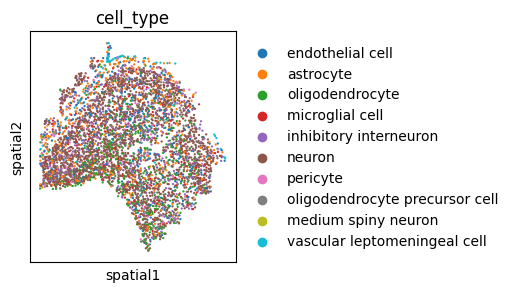

In [3]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.plotting.spatial(adata, color="cell_type", spot_size=30)

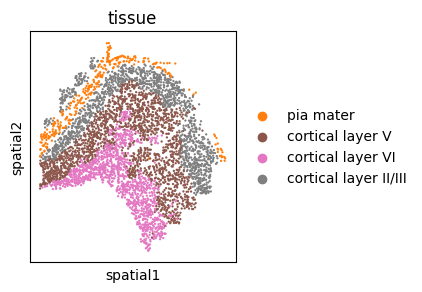

In [4]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.plotting.spatial(adata, color="tissue", spot_size=30)

## Create L-R database

In [5]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.001,
    database='CellChat',
    species='mouse'
)

In [6]:
LRDatabase_D.shape

(5, 7)

## Run SCILD

In [7]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=5,
                alpha_q=0.1,
                alpha_f=0.1,
                alpha_g=0.1,
                niter_max=100,
                eps=1e-5,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 5
The number of ligand is: 5
The number of receptor is: 7
The number of spot is: 4347



*************Solving*************
The relative error is: 0.08031515326108503
The relative error is: 0.01142103570565849
The relative error is: 0.0015690243165770855
The relative error is: 0.0002141699064941439
The relative error is: 2.920718958686283e-05

 The final relative error is: 8.836853362322644e-06
The total iteration step is: 56


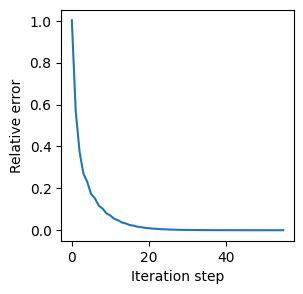

In [8]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [9]:
CCCProb.adata

AnnData object with n_obs × n_vars = 4347 × 374
    obs: 'age', 'clust_annot', 'slice', 'cell_type_annot', 'cell_type', 'disease', 'organism', 'sex', 'tissue', 'development_stage', 'x', 'y', 'n_genes'
    var: 'feature_name'
    uns: 'cell_type_colors', 'tissue_colors'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

## Extract LR CCC

In [10]:
CCCProb.query_all_LR()

In [11]:
CCCProb.tensor_P.shape

(4347, 4347, 5, 7)

In [12]:
res_dict = tensor_to_method_result(CCCProb.tensor_P, 
                                   list(CCCProb.LRDatabase_D.index), 
                                   list(CCCProb.LRDatabase_D.columns))
len(res_dict)

35

In [13]:
res_dict = filter_method_result_by_LR_database(res_dict, CCCProb.LRDatabase_D)
len(res_dict)

8

In [14]:
import pickle
with open("./results/MouseBrainMERFISH_SCILD_result.pkl", "wb") as f:
    pickle.dump(res_dict, f)

## Visualization

select L-Rs to show (spatial)

In [15]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 4347 × 16
    obsm: 'spatial'

In [16]:
LR_df_spatial = compute_spatial_autocorrelation(CCC_adata)
LR_df_spatial.sort_values('moran_I', ascending=False).head()

,moran_I,p_value
C4b->Cr2 (R),0.047813,2.025831e-13
C4b->Cr2 (S),0.044414,8.652167e-12
Ccl2->Ccr2 (R),0.012286,5.560915e-02
Vip->Vipr2 (S),0.011768,6.652739e-02
C3->Itgb2 (S),0.010452,1.023615e-01


In [17]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,age,clust_annot,slice,cell_type_annot,cell_type,disease,organism,sex,tissue,development_stage,...,C3->Itgb2 (S),C3->Itgb2 (R),C4b->Cr2 (S),C4b->Cr2 (R),Ccl2->Ccr2 (S),Ccl2->Ccr2 (R),Crh->Crhr2 (S),Crh->Crhr2 (R),Vip->Vipr2 (S),Vip->Vipr2 (R)
122184445827896016775977821870080586530,24wk,Astro-2,0,Astro,astrocyte,normal,Mus musculus,female,pia mater,24 weeks,...,0.220301,0.220301,1.021835,1.021835,0.726703,0.726703,0.639637,0.639637,1.040522,1.040522
230772751864841308557325187914799643743,24wk,Astro-1,0,Astro,astrocyte,normal,Mus musculus,female,pia mater,24 weeks,...,0.202272,0.202272,0.625757,0.625757,0.726702,0.726702,0.639636,0.639636,0.731970,0.731970
323408616655159645604868800726998552866,24wk,Olig-2,0,Olig,oligodendrocyte,normal,Mus musculus,female,pia mater,24 weeks,...,0.202273,0.202273,0.625759,0.625759,0.726703,0.726703,0.639637,0.639637,0.731971,0.731971
320911307030956433707833585273342256735,24wk,Astro-1,0,Astro,astrocyte,normal,Mus musculus,female,pia mater,24 weeks,...,0.202273,0.202273,0.625759,0.625759,0.726703,0.726703,0.639637,0.639637,0.731971,0.731971
47506129704837753302677252448919453232,24wk,Peri-1,0,Peri,pericyte,normal,Mus musculus,female,pia mater,24 weeks,...,0.218756,0.218756,0.990255,0.990255,0.726703,0.726703,0.639637,0.639637,0.731971,0.731971


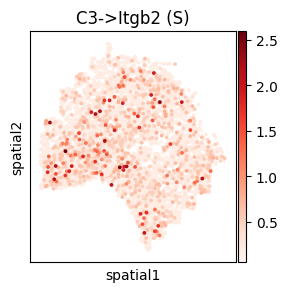

In [29]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=50, color="C3->Itgb2 (S)", cmap='Reds', img_key=None)

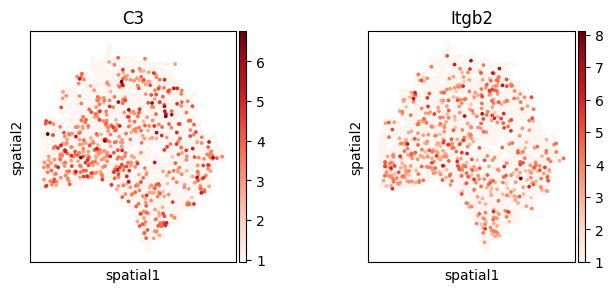

In [30]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=50, color=["C3", "Itgb2"], cmap='Reds', img_key=None)

## Cell-group level results

In [20]:
from models.help_func import aggregate_to_group

In [21]:
cell_to_group = adata.obs['tissue'].to_dict()
group_result = {}
for lr_key, matrix in res_dict.items():
    group_matrix = aggregate_to_group(matrix, cell_to_group)
    group_result[lr_key] = group_matrix.values

In [23]:
cell_to_group = adata.obs['cell_type'].to_dict()
group_result = {}
for lr_key, matrix in res_dict.items():
    group_matrix = aggregate_to_group(matrix, cell_to_group)
    group_result[lr_key] = group_matrix.values